In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pyfftw
from pyfftw.interfaces.numpy_fft import fftshift
from pyfftw.interfaces.numpy_fft import ifftshift
from pyfftw.interfaces.numpy_fft import rfftn
from pyfftw.interfaces.numpy_fft import irfftn
from pyfftw.interfaces.numpy_fft import rfft2
from pyfftw.interfaces.numpy_fft import irfft2
import scipy as sp
import seaborn as sns

from pyem import mrc
from pyem.util import *
from pyem.vop import *

%matplotlib inline
sns.set()
pyfftw.interfaces.cache.enable()

In [21]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [63]:
def radial_sum(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
#     radialsum = sp.stats.binned_statistic(r.ravel(), data.ravel(), "sum", 192)
    tbin = np.bincount(r.ravel(), data.ravel())
    return tbin

In [120]:
def fourier_ring_correlation(p1, p2):
    center = (0, p1.shape[0] // 2)
    fc = fftshift(p1 * np.conj(p2), axes=0)
    fcr = radial_sum(np.real(fc), center)
    fcc = radial_sum(np.imag(fc), center)
    mag = np.sqrt(radial_sum(np.abs(fftshift(p1, axes=0))**2, center) * 
                  radial_sum(np.abs(fftshift(p2, axes=0))**2, center))
    frc = (fcr + fcc*1j) / mag
    return frc

In [155]:
disc, hdr = mrc.read("cryosparc_exp000406_022.mrc", inc_header=True, compat="relion")

In [156]:
pfac = 2
vol = grid_correct(np.double(disc), pfac=pfac, order=1)
padvol = np.pad(vol, (vol.shape[0] * pfac - vol.shape[0]) // 2, "constant")
discft = rfftn(ifftshift(padvol), padvol.shape, threads=8)

In [157]:
discftc = np.zeros((387,387,194), dtype=np.complex128)
fill_ft(discft, discftc, 192)

In [158]:
a = np.arange(-45,225)
rots = [euler2rot(*np.deg2rad([15,90,i])) for i in a]
sz = [192, 96, 48]

In [159]:
xc = np.zeros((len(rots), 3))
pc = np.zeros((len(rots), 3))
for i in range(len(rots)):
    for j in range(len(sz)):
        p1 = interpolate_slice_numba(discftc, rots[45], size=sz[j])
        p2 = interpolate_slice_numba(discftc, rots[i], size=sz[j])
        p1p2 = p1 * np.conj(p2)
        xc[i,j] = np.max(irfft2(p1p2))
        pc[i,j] = np.max(irfft2(p1p2 / (np.abs(p1p2) + 1e-17)))

In [115]:
p1 = interpolate_slice_numba(discftc, rots[45], size=sz[0])
p2 = interpolate_slice_numba(discftc, rots[45], size=sz[0])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


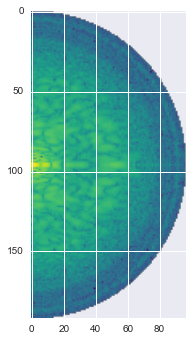

In [81]:
plt.imshow(fftshift(np.log(np.abs(np.sqrt(p1 * np.conj(p1)))), axes=0), cmap="viridis")

In [165]:
center = (0,96)
y, x = np.indices((p1.shape))
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
r = r.astype(np.int)

In [166]:
np.sqrt(2 * 96**2)

135.76450198781711

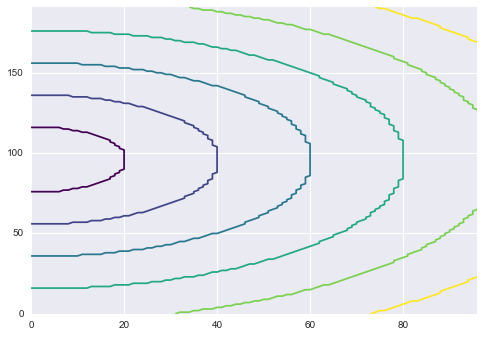

In [167]:
plt.contour(r, cmap="viridis")

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


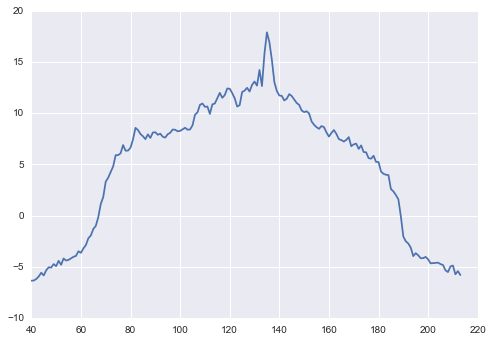

In [168]:
plt.plot(np.log(radial_profile(fftshift(np.abs(p1 * np.conj(p1)), axes=0), (96,0))))
# plt.ylim((0,100))

In [123]:
fc = fftshift(p1 * np.conj(p2), axes=0)
fcr = radial_sum(np.real(fc), (0,96))
fcc = radial_sum(np.imag(fc), (0,96))
mag = np.sqrt(radial_sum(np.abs(fftshift(p1, axes=0))**2, (0,96)) * 
              radial_sum(np.abs(fftshift(p2, axes=0))**2, (0,96)))
frc = (fcr + fcc*1j) / mag

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


(20, 0)

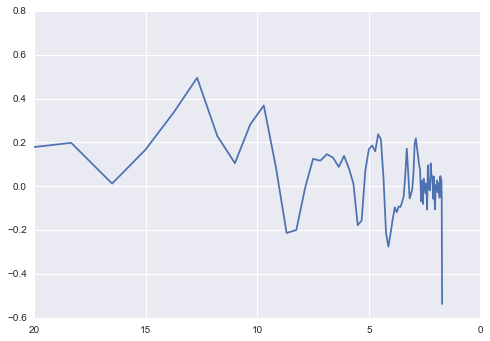

In [124]:
plt.plot(1.2156/(radial_profile(r, (0,96)) / np.sqrt(2 * 96**2)), frc)
plt.xlim((20,0))

In [127]:
np.nanmax(np.real(frc))

1.0

In [174]:
p1 = interpolate_slice_numba(discftc, rots[45], size=sz[0])
frc0 = fourier_ring_correlation(p1, p1)
N = 11
frc = np.zeros((N, frc0.size))
frc[0] = frc0
idx = [45, 46, 60, 75, 90, 135, 180, 195, 210, 226, 225]
for i in range(N):
    p2 = interpolate_slice_numba(discftc, rots[idx[i]], size=sz[0])
    frc[i] = fourier_ring_correlation(p1, p2)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


(15, 0)

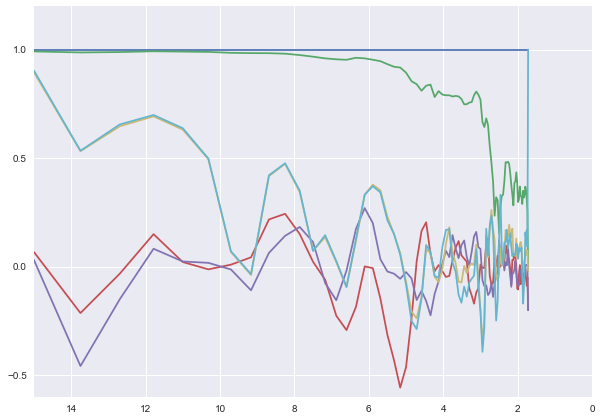

In [183]:
f, ax = plt.subplots(1, figsize=(10, 7))
ax.plot(1.2156/(radial_profile(r, (0,96)) / np.sqrt(2 * 96**2)), frc[[0,1,2,-3,-2,-1]].T)
ax.set_xlim((15,0))

In [171]:
frc_180 = fourier_ring_correlation(interpolate_slice_numba(discftc, rots[45], size=sz[0]),
                                  interpolate_slice_numba(discftc, rots[225], size=sz[0]))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


(15, 0)

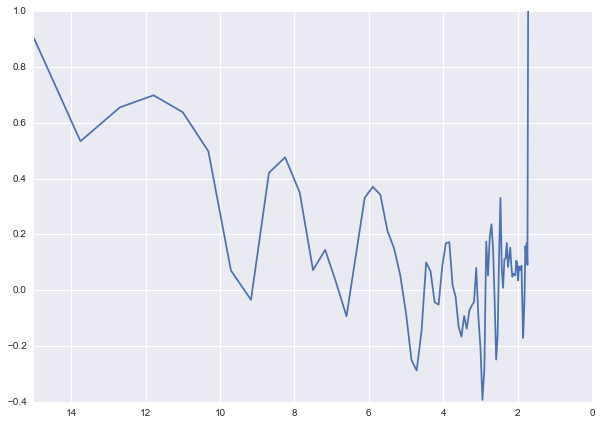

In [172]:
f, ax = plt.subplots(1, figsize=(10, 7))
ax.plot(1.2156/(radial_profile(r, (0,96)) / np.sqrt(2 * 96**2)), frc_180.T)
ax.set_xlim((15,0))